In [ ]:
##################################################################################
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
###################################################################################

# Data beans image social media image generation

This notebook generate images based on the social media review description on the data beans table `data_beans.customer_review`
It performs the following steps:

 - Generate the images using `imagen2`model - results will be saved to `IMAGE_GEN_DIR`, prompts will be saved to `PROMPT_FILE_NAME`
 - Perfom logo detection using `Vision API` - results will be saved to `IMAGE_EVAL_FILE_NAME_LOGO`
 - Perform text detection using `Vision API` + `Gemini Pro` to ensure the text detected is an actual English word - - results will be saved to `IMAGE_EVAL_FILE_NAME_TEXT`
 - Perform face quality scoring using two different techniques - - results will be saved to `IMAGE_EVAL_FILE_NAME_FACE`
      - A custom face quality CNN classifier model
      - A scoring based on  `Gemini Pro Vision`

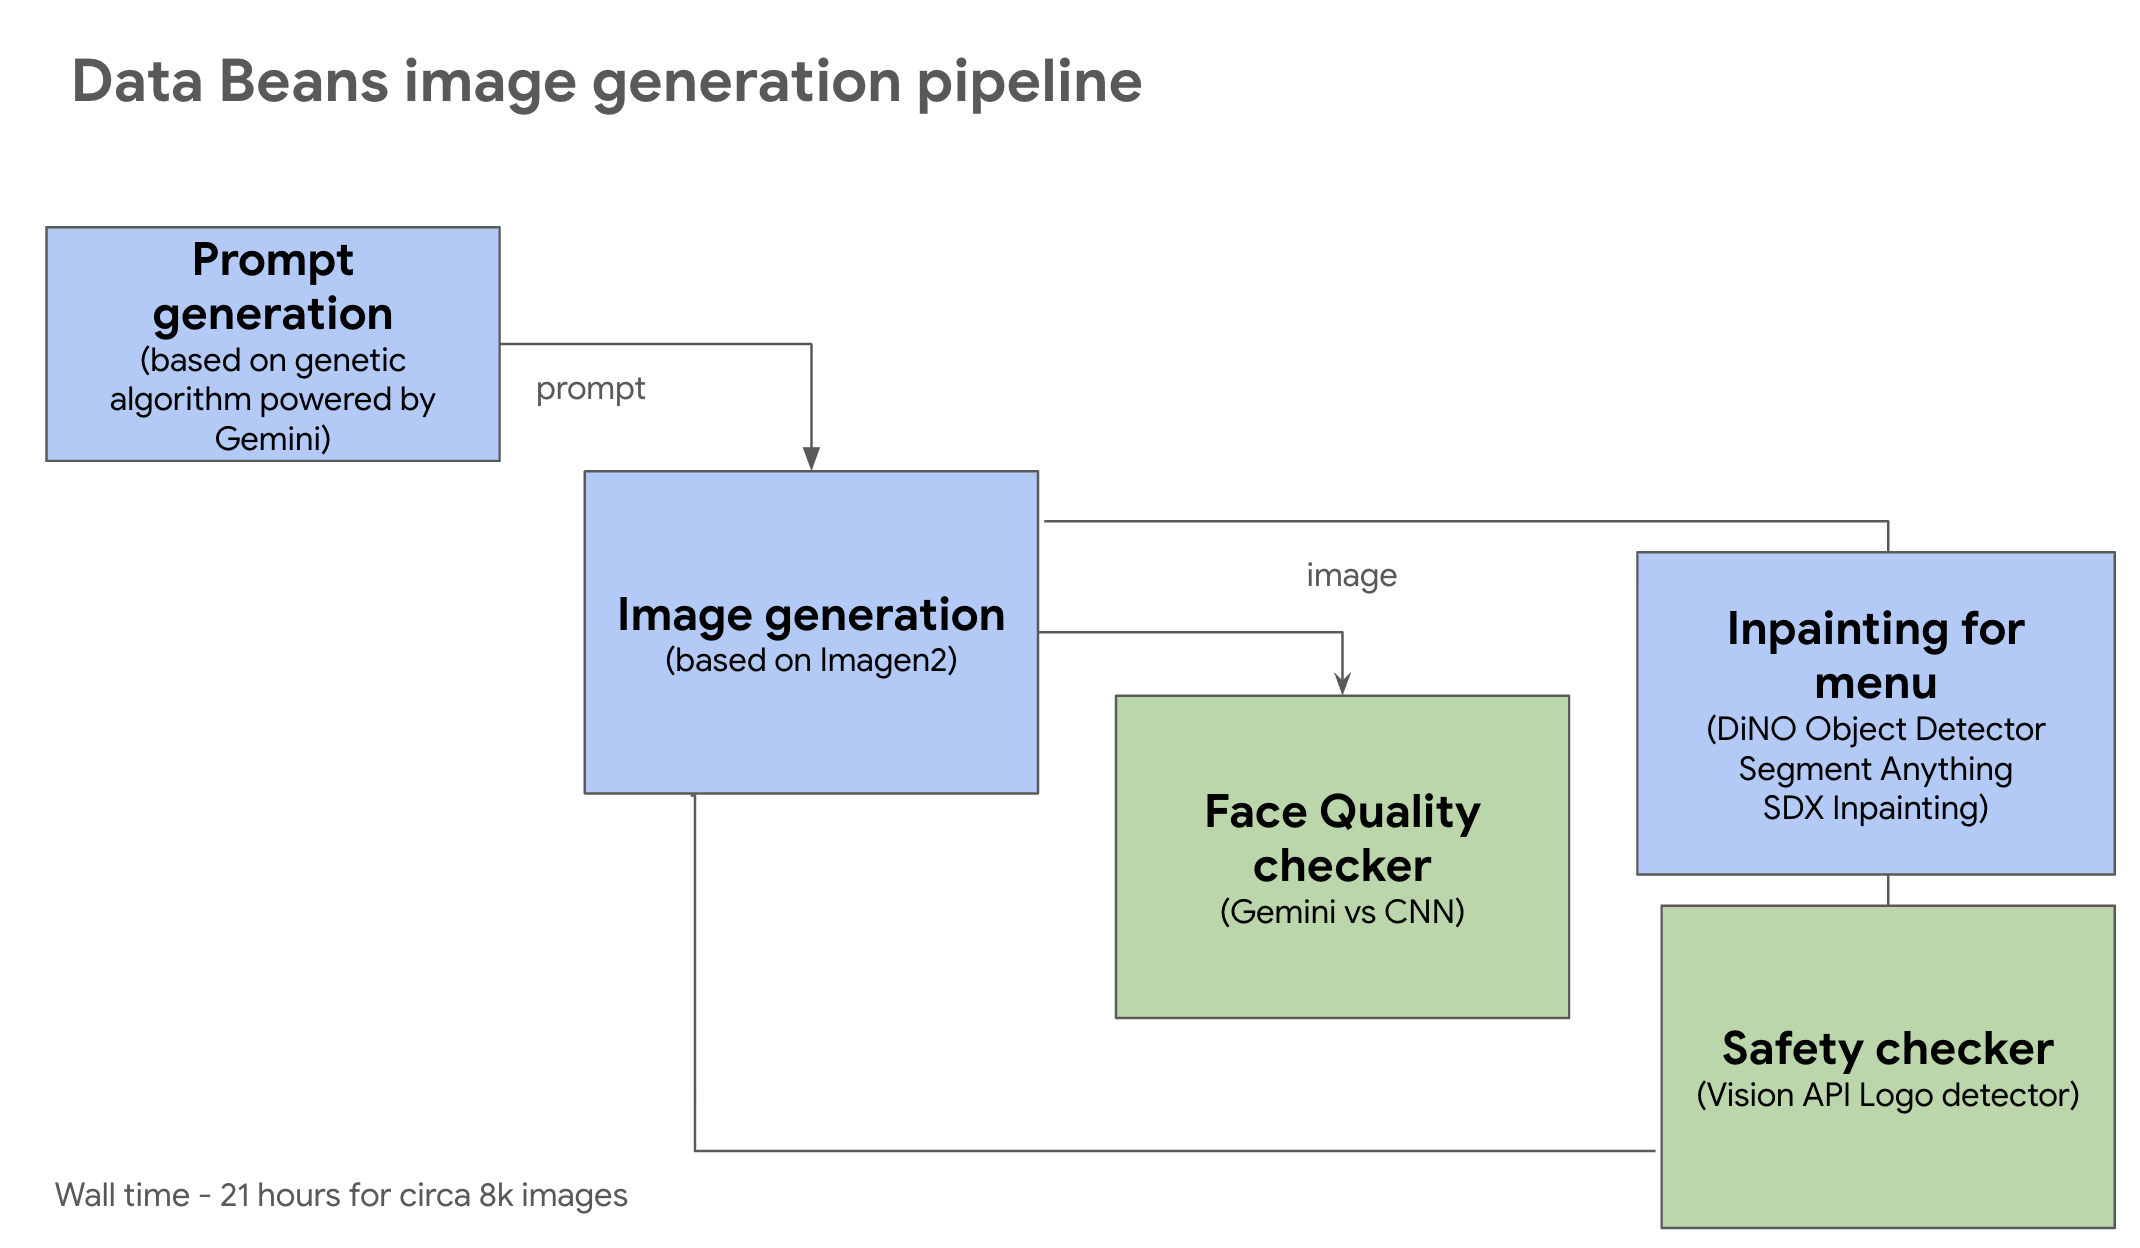

## Imports and parameters

In [ ]:
! pip install google-cloud-vision
! pip3 install --upgrade --user google-cloud-aiplatform

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [ ]:
import google.auth
import google.auth.transport.requests
import requests
import json
import logging
import base64
import os
import io
import random
import csv
import cv2
import statistics
import numpy as np
import ast
import pandas as pd

from PIL import Image
from enum import Enum
from google.cloud import bigquery
from google.cloud import vision
from tqdm import tqdm
from IPython.display import Image as ipython_image
from IPython.display import display

from vertexai.preview.generative_models import GenerativeModel,GenerationConfig
from vertexai.preview import generative_models

In [ ]:
PROJECT_ID = "${project_id}"
DATASET_ID = "${bigquery_data_beans_curated_dataset}"
LOCATION = "us-central1"
IMAGEN_MODEL = "imagegeneration@005"
MAX_SEED = 1000000
IMAGE_GEN_DIR = "beans_images"
TABLE_ID = "customer_review"
PROMPT_FILE_NAME = "prompts.csv"
IMAGE_EVAL_FILE_NAME_LOGO = "image_eval_logo.csv"
IMAGE_EVAL_FILE_NAME_FACE = "image_eval_face.csv"
IMAGE_EVAL_FILE_NAME_TEXT = "image_eval_text.csv"

class PromtType(Enum):
    PROMPT_TYPE_A = 0
    PROMPT_TYPE_B = 1
    PROMPT_TYPE_C = 2

In [ ]:
logging.getLogger().setLevel(logging.INFO)
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_QUOTA_PROJECT"] = PROJECT_ID

## Auxiliary functions

In [ ]:
def _get_image_pil(IMAGE_GEN_DIR,id):
    image = Image.open(os.path.join(IMAGE_GEN_DIR,f"image_{id}.png"))
    return image

def _check_has_logo(content):
    logo_confidence_threshold = 0.85
    client = vision.ImageAnnotatorClient()
    image = vision.Image(content=content)
    logo_detections = client.logo_detection(image=image).logo_annotations
    if logo_detections:
        if logo_detections[0].score > logo_confidence_threshold:
            brand_name = logo_detections[0].description
            return True, brand_name
        else:
            return False,""
    else:
        return False,""

def _is_good_text(text):
    gemini_pro_model = GenerativeModel("gemini-pro")
    eval_prompt=f"""
       You are a expert English dictionary.
       Your task is to validate if a word is an actual English word or not.
       Reply only with True if the word is an English word or False if not.
       The word to check is: {text}
        """
    generation_config = GenerationConfig(
        temperature=0,
        top_p=1.0,
        top_k=32,
        candidate_count=1)
    model_response = gemini_pro_model.generate_content(eval_prompt,generation_config=generation_config)
    response = ast.literal_eval(model_response.candidates[0].content.parts[0].text)
    return response

def _check_has_correct_text(content):
    client = vision.ImageAnnotatorClient()
    image = vision.Image(content=content)
    text_detections = client.text_detection(image=image).text_annotations
    all_good_text = True
    for text_detection in text_detections:
        text = text_detection.description
        if not _is_good_text(text):
            all_good_text = False
            break
    return  all_good_text

def _image_to_byte_array(image):
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format="PNG")
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

def _get_image_from_path(path):
    image = Image.open(path)
    return _image_to_byte_array(image)

def _get_reviews():
    client = bigquery.Client()
    sql = f"""
    SELECT *
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE review_image_filename is null
    ORDER BY customer_review_id
    """
    return client.query(sql).to_dataframe()

def _get_processed_ids(directory):
    ids = []
    for file in os.listdir(directory):
        if file.endswith(".png"):
            id = int(file.split("_")[1].split(".")[0])
            ids.append(id)
    return ids

def _gen_prompt(review_sentiment):
    prompt_type = random.choice([PromtType.PROMPT_TYPE_A,PromtType.PROMPT_TYPE_A,PromtType.PROMPT_TYPE_B,PromtType.PROMPT_TYPE_C])
    if prompt_type == PromtType.PROMPT_TYPE_A:
            reviewer = random.choice(['man','woman'])
            location = random.choice(['big city street corner','big city park','big city square'])
            action = random.choice(['holding','drinking','chilling with'])
            extra = random.choice(['','The barista is preparing coffee.','There are other friends around.'])
            weather = random.choice(['Its a beatiful sunny day.','sunny day','cloudy day'])
            prompt = f"Half body picture of a {reviewer} looking at the camera,  theres a coffee truck behind in the middle of {location} {action} a cup of coffee to go. {extra} {weather}.Photorealistc, 8k"
    elif prompt_type == PromtType.PROMPT_TYPE_B:
            reviewer = random.choice(['man','woman'])
            location = random.choice(['inside of a car','on a department store','walking down the street'])
            extra = random.choice([ "blurred background","taken by a professional photographer", "DSLR style","using high shutter speed", "4k"])
            prompt = f"Close shot of a {reviewer} enjoying a cup of coffee to go, in a  {location} . {extra}"
    elif prompt_type == PromtType.PROMPT_TYPE_C:
            item = random.choice(['black coffe','capuccino', 'latte', 'espresso' ])
            prompt = f"Close shot of a {item}. Photorealistc, 8k"
    else:
        raise Exception(f"Prompt Type {prompt_type} not supported")
    prompt = prompt + f" , tone of the image is {review_sentiment}"
    return prompt

def _save_logo_check(id,brand_name):
       with open(os.path.join(IMAGE_EVAL_FILE_NAME_LOGO), "a") as f:
            csvwriter = csv.writer(f, delimiter='|',lineterminator='\n')
            csvwriter.writerow((id, brand_name))

def _save_text_check(id):
       with open(os.path.join(IMAGE_EVAL_FILE_NAME_TEXT), "a") as f:
            csvwriter = csv.writer(f, delimiter='|',lineterminator='\n')
            csvwriter.writerow([id])

def _save_gemini_check(image_id,score):
    with open(os.path.join(IMAGE_EVAL_FILE_NAME_FACE), "a") as f:
        csvwriter = csv.writer(f, delimiter='|',lineterminator='\n')
        csvwriter.writerow((image_id, score))

def _detect_faces(content):
    client = vision.ImageAnnotatorClient()
    image = vision.Image(content=content)
    face_detections = client.face_detection(image=image).face_annotations
    return face_detections

def _crop_faces(image_bytes):
    nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    face_detections = _detect_faces(image_bytes)
    cropped_faces = []
    for face in face_detections:
        vertices = face.bounding_poly.vertices
        x0 = round(vertices[0].x)
        y0 = round(vertices[0].y)
        x1 = round(vertices[2].x)
        y1 = round(vertices[2].y)
        crop = image[y0:y1, x0:x1]
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        cropped_faces.append(Image.fromarray(crop_rgb))
    return cropped_faces

def _save_image(response,id):
    image_data = json.loads(response.content)["predictions"][0]["bytesBase64Encoded"]
    image_data = base64.b64decode(image_data)
    with open(os.path.join(IMAGE_GEN_DIR,f"image_{id}.png"), "wb") as f:
              f.write(image_data)

def _save_prompt(promtp,id):
       with open(os.path.join(PROMPT_FILE_NAME), "a") as f:
            csvwriter = csv.writer(f, delimiter='|',lineterminator='\n')
            csvwriter.writerow((id, promtp))

def _gen_image(prompt,id):
    try:
        creds, project = google.auth.default()
        auth_req = google.auth.transport.requests.Request()
        creds.refresh(auth_req)
        project = PROJECT_ID
        location = LOCATION
        model_id = IMAGEN_MODEL
        access_token = creds.token
        parameters = {"seed": random.randint(1, MAX_SEED),"sampleCount": 1,"aspectRatio": "1:1","negativePrompt": "ugly","outputOptions": {"mimeType": "image/png"}}
        payload = {"instances": [{"prompt": prompt}],"parameters": parameters}
        headers = {"Content-Type": "application/json","Authorization": "Bearer " + access_token}
        url = f"https://{location}-aiplatform.googleapis.com/v1/projects/{project}/locations/{location}/publishers/google/models/{model_id}:predict"
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code == 200:
            _save_prompt(prompt,id)
            _save_image(response,id)
        else:
            logging.info(f"{id} -- Error with  prompt {prompt}:", response.status_code, response.text)
    except:
        pass

## Image generation process

In [ ]:
def gen_images():
    os.makedirs(IMAGE_GEN_DIR, exist_ok=True)
    processed_ids = _get_processed_ids(IMAGE_GEN_DIR)
    reviews_pd = _get_reviews()
    for _ , row in tqdm(reviews_pd.iterrows(), total=len(reviews_pd), desc="Generating Images"):
        review_sentiment = row['review_sentiment']
        customer_review_id = row['customer_review_id']
        if not customer_review_id in processed_ids:
            prompt = _gen_prompt(review_sentiment)
            _gen_image(prompt,customer_review_id)
        else:
            logging.info(f"{customer_review_id} -- Already processed")

In [ ]:
gen_images()

In [ ]:
processed_ids = _get_processed_ids(IMAGE_GEN_DIR)

for item in processed_ids:
  filename = os.path.join(IMAGE_GEN_DIR,f"image_{item}.png")
  print(filename)
  img = Image.open(filename)
  img.thumbnail([500,500])
  IPython.display.display(img)  

## Logo (brands) checker

In [ ]:
def eval_images_logo():
    processed_ids = _get_processed_ids(IMAGE_GEN_DIR)
    for image_id in tqdm(processed_ids, total=len(processed_ids), desc="Analyzing Images - Logos"):
        image = _get_image_pil(IMAGE_GEN_DIR,str(image_id))
        has_logo, brand_name = _check_has_logo(_image_to_byte_array(image))
        if has_logo:
            _save_logo_check(image_id,brand_name)

In [ ]:
eval_images_logo()

In [ ]:
if os.path.exists(os.path.join(IMAGE_EVAL_FILE_NAME_LOGO)):
    logging.info(f"Images ids with logos:")
    display(pd.read_csv(os.path.join(IMAGE_EVAL_FILE_NAME_LOGO), sep='|'))
else:
   logging.info(f"No logos detected")

## Text quality checker

In [ ]:
def eval_images_text():
    processed_ids = _get_processed_ids(IMAGE_GEN_DIR)
    for image_id in tqdm(processed_ids, total=len(processed_ids), desc="Analyzing Images - Text"):
        image = _get_image_pil(IMAGE_GEN_DIR,str(image_id))
        good_text = _check_has_correct_text(_image_to_byte_array(image))
        logging.info(f"good_text: {good_text}")
        if not good_text:
            _save_text_check(image_id)

In [ ]:
eval_images_text()

In [ ]:
if os.path.exists(os.path.join(IMAGE_EVAL_FILE_NAME_TEXT)):
    logging.info(f"Images ids with bad text:")
    display(pd.read_csv(os.path.join(IMAGE_EVAL_FILE_NAME_TEXT), sep='|'))
else:
   logging.info(f"No bad text detected")

## Face quality checker with Gemini

In [ ]:
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/train/good_faces/0003.png  good_face_0001.png
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/train/good_faces/0008.png  good_face_0002.png
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/train/good_faces/0016.png  bad_face_0001.png
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/train/good_faces/0018.png  bad_face_0002.png

In [ ]:
def _adapt_code_response(raw_response):
    result = raw_response.replace("```json\n","")
    result = result.replace("```JSON\n","")
    result = result.replace("```json","")
    result = result.replace("```JSON","")
    result = result.replace("```sql\n","")
    result = result.replace("```SQL\n","")
    result = result.replace("```sql","")
    result = result.replace("```SQL","")
    result = result.replace("```","")
    return result

def predict_face_quality_gemini(image):
    part_a_image = _get_image_from_path("good_face_0001.png")
    part_b_image = _get_image_from_path("bad_face_0001.png")
    part_c_image = _get_image_from_path("good_face_0002.png")
    part_d_image = _get_image_from_path("bad_face_0002.png")

    part_a = generative_models.Part.from_data(part_a_image,mime_type="image/png")
    part_b = generative_models.Part.from_data(part_b_image,mime_type="image/png")
    part_c = generative_models.Part.from_data(part_c_image,mime_type="image/png")
    part_d = generative_models.Part.from_data(part_d_image,mime_type="image/png")

    part_image_to_rate = generative_models.Part.from_data(_image_to_byte_array(image),mime_type="image/png")
    example_return_json='[ {"rating" : 10, "explanation": ""}]'
    eval_prompt=[ f"""
       For the below image rate it on a scale of 1 to 100, 100 being the highest.
        - Rate the image high if the faces in the image are symmetrical
        - Rate the image low if it looks like a cartoon image
        - Rate the image high if it is realistic
        - Rate the image low if the skin tone is different on the face and arms
        - Rate the image low if the eyes are not clearly defined
        - Image A is an example of a good image, with a score of 95
        - Image B is an example of a bad image, with a score of 5
        - Image C is an example of a good image, with a score of 95
        - Image D is an example of a bad image, with a score of 5

        Image A: """, part_a , """  Image B: """, part_b, """Image C: """, part_c , """  Image D: """, part_d,
        """Image to rate:""", part_image_to_rate,

        f"""Place the result of the scoring process in the "rating" field.
        Explain your reasoning and place in the "explanation" field in less than 20 words.

        Place the results in the following JSON structure:
        {example_return_json}
        """]

    gemini_pro_vision_model = GenerativeModel("gemini-pro-vision")
    generation_config = GenerationConfig(
        temperature=0,
        top_p=1.0,
        top_k=32,
        candidate_count=1)
    model_response = gemini_pro_vision_model.generate_content(eval_prompt,generation_config=generation_config)
    parsed_model_response = _adapt_code_response(model_response.candidates[0].content.parts[0].text)
    response = ast.literal_eval(parsed_model_response)
    return response

In [ ]:
def get_face_quality(image):
    rating_list = []
    cropped_faces = _crop_faces(_image_to_byte_array(image))
    for face in cropped_faces:
        rating_list.append(predict_face_quality_gemini(face)[0]['rating'])
    if len(rating_list) > 0:
        return statistics.mean(rating_list)
    else:
        return 0

In [ ]:
def eval_images_face():
    processed_ids = _get_processed_ids(IMAGE_GEN_DIR)
    for image_id in tqdm(processed_ids, total=len(processed_ids), desc="Analyzing Images - Faces"):
        image = _get_image_pil(IMAGE_GEN_DIR,str(image_id))
        gemini_score = get_face_quality(image)
        logging.info(f"Gemini 4 shot score is: {gemini_score}")
        if gemini_score < 20:
            _save_gemini_check(image_id,gemini_score)

In [ ]:
eval_images_face()

In [ ]:
if os.path.exists(os.path.join(IMAGE_EVAL_FILE_NAME_FACE)):
    logging.info(f"Images ids with bad faces:")
    display(pd.read_csv(os.path.join(IMAGE_EVAL_FILE_NAME_FACE), sep='|'))
else:
   logging.info(f"No bad faces detected")

In [ ]:
def run_pipeline():
    gen_images()
    eval_images_logo()
    eval_images_text()
    eval_images_face()